<a href="https://colab.research.google.com/github/vquant25/Differential-equations-with-python/blob/main/Copy_of_BSM_PDE_PINNS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# reproducible
torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Neural Network definition
# ----------------------------
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        layer_list = []
        for i in range(len(layers)-2):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            layer_list.append(nn.Tanh())
        layer_list.append(nn.Linear(layers[-2], layers[-1]))
        self.model = nn.Sequential(*layer_list)

    def forward(self, x, t):
        XT = torch.cat([x, t], dim=1)
        return self.model(XT)

# ----------------------------
# PDE Residual - Loss function
# ----------------------------
def pde_residual(x, t, model):
    # ensure requires_grad for derivatives
    x = x.clone().detach().requires_grad_(True)
    t = t.clone().detach().requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    return u_t - u_xx, u, x, t  # return extras if needed for diagnostics

# ----------------------------
# Training setup
# ----------------------------
layers = [2, 50, 50, 50, 1]
model = PINN(layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Collocation points (interior)
N_f = 5000
x_f = torch.rand((N_f,1), device=device)
t_f = torch.rand((N_f,1), device=device)

# Initial condition points (t=0)
N0 = 200
x0 = torch.rand((N0,1), device=device)
t0 = torch.zeros((N0,1), device=device)
u0 = torch.sin(torch.pi * x0)               # <--- use torch.sin and keep on device

# Boundary condition points (x=0 and x=1 at random times)
Nb = 200
tb = torch.rand((Nb,1), device=device)
x_lb = torch.zeros((Nb,1), device=device)
x_ub = torch.ones((Nb,1), device=device)

# Loss weights (important)
lambda_ic = 200.0  # strengthen initial condition enforcement
lambda_bc = 200.0

# ----------------------------
# Training loop
# ----------------------------
n_epochs = 10000
print_every = 500

loss_history = []
mse_history = []

for epoch in range(n_epochs):
    optimizer.zero_grad()

    if epoch % 200 == 0:
        x_f = torch.rand((N_f,1), device=device)
        t_f = torch.rand((N_f,1), device=device)

    # PDE residual loss
    f_res, _, _, _ = pde_residual(x_f, t_f, model)
    loss_pde = torch.mean(f_res**2)

    # Initial condition loss
    u_pred0 = model(x0, t0)
    loss_ic = torch.mean((u_pred0 - u0)**2)

    # Boundary condition loss
    u_lb = model(x_lb, tb)
    u_ub = model(x_ub, tb)
    loss_bc = torch.mean(u_lb**2) + torch.mean(u_ub**2)

    # Weighted total loss
    loss = loss_pde + lambda_ic * loss_ic + lambda_bc * loss_bc



    # Record losses
    loss_history.append(loss.item())
    mse_history.append(loss_ic.item())

    loss.backward()
    optimizer.step()

    if epoch % print_every == 0:
        print(f"Epoch {epoch:6d}  Total={loss.item():.3e}  PDE={loss_pde.item():.3e}  IC={loss_ic.item():.3e}  BC={loss_bc.item():.3e}")

# ----------------------------
# Evaluation: slice at t=0.5
# ----------------------------
x_vals = np.linspace(0,1,100).reshape(-1,1)
x_test = torch.tensor(x_vals, dtype=torch.float32).to(device)
t_test = torch.ones_like(x_test) * 0.5

with torch.no_grad():
    u_pred = model(x_test, t_test).detach().cpu().numpy()

u_exact = np.exp(-np.pi**2 * 0.5) * np.sin(np.pi * x_vals)

# Table
print("\nResults at t=0.5 (first 12 pts)")
print(" x    Predicted    Exact     AbsError")
for i in range(12):
    print(f"{x_vals[i,0]:.3f}  {u_pred[i,0]:.6e}  {u_exact[i,0]:.6e}  {abs(u_pred[i,0]-u_exact[i,0]):.2e}")


Epoch      0  Total=7.943e+01  PDE=2.784e-03  IC=3.765e-01  BC=2.062e-02
Epoch    500  Total=3.659e-01  PDE=2.744e-01  IC=2.375e-04  BC=2.201e-04
Epoch   1000  Total=1.794e-01  PDE=6.571e-02  IC=2.731e-04  BC=2.955e-04
Epoch   1500  Total=3.647e-02  PDE=2.777e-02  IC=2.410e-05  BC=1.941e-05
Epoch   2000  Total=2.100e-02  PDE=1.587e-02  IC=1.283e-05  BC=1.286e-05
Epoch   2500  Total=1.674e-02  PDE=1.343e-02  IC=6.886e-06  BC=9.656e-06
Epoch   3000  Total=1.253e-02  PDE=1.034e-02  IC=3.932e-06  BC=7.051e-06
Epoch   3500  Total=8.639e-03  PDE=7.071e-03  IC=3.060e-06  BC=4.778e-06
Epoch   4000  Total=6.929e-03  PDE=5.838e-03  IC=1.627e-06  BC=3.828e-06
Epoch   4500  Total=5.482e-03  PDE=4.674e-03  IC=1.453e-06  BC=2.590e-06
Epoch   5000  Total=3.881e-03  PDE=3.403e-03  IC=6.598e-07  BC=1.728e-06
Epoch   5500  Total=2.776e-03  PDE=2.438e-03  IC=3.328e-07  BC=1.355e-06
Epoch   6000  Total=2.560e-03  PDE=2.111e-03  IC=8.508e-07  BC=1.396e-06
Epoch   6500  Total=1.814e-03  PDE=1.635e-03  IC=2.

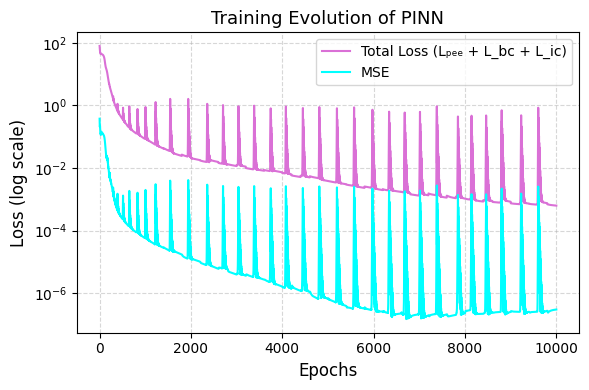

In [ ]:
import matplotlib.pyplot as plt

epochs_arr = np.arange(len(loss_history))

plt.figure(figsize=(6,4))
plt.semilogy(epochs_arr, loss_history, label="Total Loss (Lₚₑₑ + L_bc + L_ic)", color='orchid')
plt.semilogy(epochs_arr, mse_history, label="MSE", color='cyan')

plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss (log scale)", fontsize=12)
plt.title("Training Evolution of PINN", fontsize=13)
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


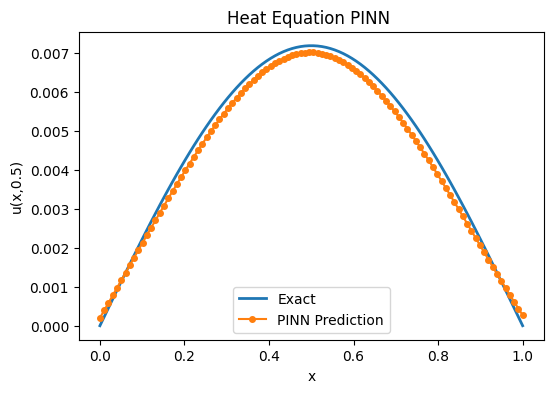

In [ ]:
# Plot
plt.figure(figsize=(6,4))
plt.plot(x_vals, u_exact, label="Exact", lw=2)
plt.plot(x_vals, u_pred, 'o-', label="PINN Prediction", markersize=4)
plt.legend()
plt.xlabel("x")
plt.ylabel("u(x,0.5)")
plt.title("Heat Equation PINN ")
plt.show()

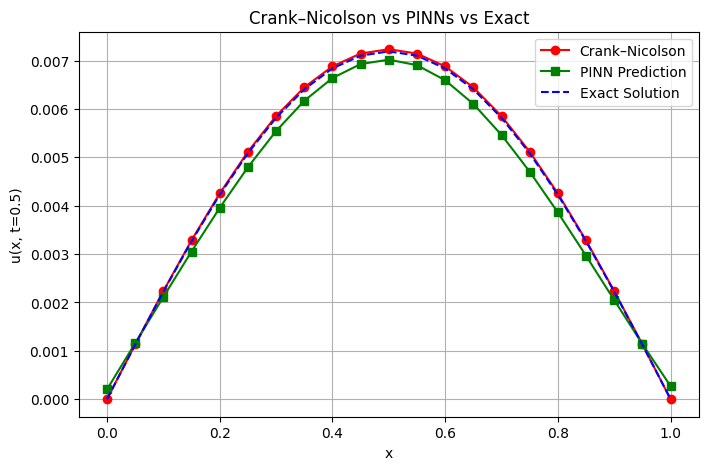

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
import torch

# -----------------------------
# Parameters
# -----------------------------
Nx = 20       # spatial steps
Nt = 100      # time steps
L = 1.0
T = 1.0
dx = L / Nx
dt = T / Nt
alpha = dt / (dx**2)

# Grid
x = np.linspace(0, L, Nx+1)
t = np.linspace(0, T, Nt+1)

# -----------------------------
# Crank–Nicolson method
# -----------------------------
u_cn = np.zeros((Nt+1, Nx+1))
u_cn[0, :] = np.sin(np.pi * x)

A = np.zeros((Nx-1, Nx-1))
B = np.zeros((Nx-1, Nx-1))
for i in range(Nx-1):
    A[i, i] = 1 + alpha
    B[i, i] = 1 - alpha
    if i > 0:
        A[i, i-1] = -alpha/2
        B[i, i-1] = alpha/2
    if i < Nx-2:
        A[i, i+1] = -alpha/2
        B[i, i+1] = alpha/2

# Time stepping
for n in range(0, Nt):
    b = B @ u_cn[n, 1:-1]
    u_cn[n+1, 1:-1] = solve(A, b)

# -----------------------------
# PINN Prediction at t = 0.5
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your trained PINN model here if saved:
# model = torch.load("pinn_model.pth", map_location=device)

# Assuming `model` is already defined and trained in this session:
x_tensor = torch.tensor(x.reshape(-1,1), dtype=torch.float32).to(device)
t_tensor = torch.ones_like(x_tensor) * 0.5
u_pinn = model(x_tensor, t_tensor).detach().cpu().numpy().flatten()

# -----------------------------
# Exact solution
# -----------------------------
t_snap = 0.5
u_exact = np.exp(-np.pi**2 * t_snap) * np.sin(np.pi * x)

# -----------------------------
# Plot comparison
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(x, u_cn[int(t_snap * Nt), :], 'o-', color='red', label="Crank–Nicolson")
plt.plot(x, u_pinn, 's-', color='green', label="PINN Prediction")
plt.plot(x, u_exact, '--', color='blue', label="Exact Solution")

plt.xlabel("x")
plt.ylabel("u(x, t=0.5)")
plt.title("Crank–Nicolson vs PINNs vs Exact")
plt.legend()
plt.grid(True)
plt.show()


Epoch     1 total=1.020e+03 pde=1.592e-02 ic=7.113e-01 bc=4.386e+00
Epoch     2 total=7.579e+02 pde=2.715e-03 ic=4.617e-01 bc=3.328e+00
Epoch     3 total=5.535e+02 pde=1.366e-03 ic=3.016e-01 bc=2.466e+00
Epoch     4 total=3.941e+02 pde=1.064e-02 ic=2.149e-01 bc=1.756e+00
Epoch     5 total=2.744e+02 pde=3.017e-02 ic=1.937e-01 bc=1.178e+00
Epoch     6 total=1.925e+02 pde=6.237e-02 ic=2.328e-01 bc=7.292e-01
Epoch     7 total=1.454e+02 pde=1.102e-01 ic=3.200e-01 bc=4.065e-01
Epoch     8 total=1.248e+02 pde=1.737e-01 ic=4.270e-01 bc=1.962e-01
Epoch     9 total=1.178e+02 pde=2.504e-01 ic=5.148e-01 bc=7.272e-02
Epoch    10 total=1.134e+02 pde=3.280e-01 ic=5.529e-01 bc=1.254e-02
Epoch   500 total=3.896e-01 pde=1.860e-01 ic=8.499e-04 bc=1.681e-04
Epoch  1000 total=2.102e-01 pde=2.298e-02 ic=8.044e-04 bc=1.317e-04
Epoch  1500 total=1.946e-01 pde=1.476e-02 ic=7.887e-04 bc=1.107e-04
Epoch  2000 total=1.864e-01 pde=1.615e-02 ic=7.322e-04 bc=1.191e-04
Epoch  2500 total=1.814e-01 pde=1.799e-02 ic=6.9

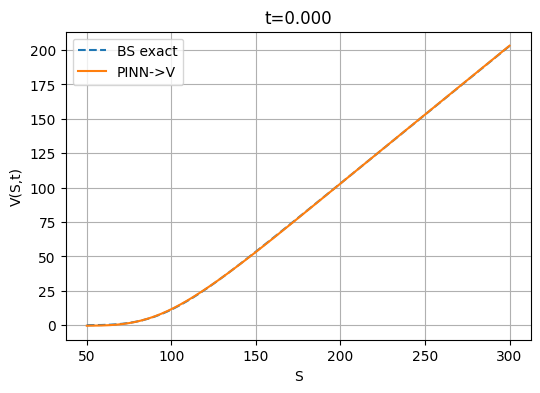

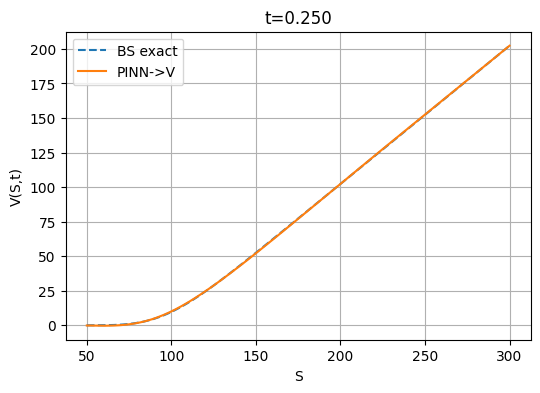

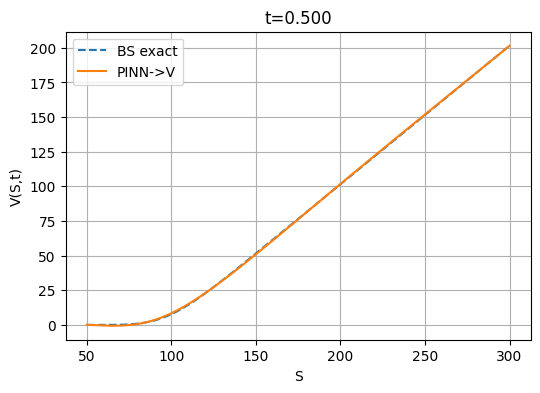

In [ ]:
# Paste into Colab (GPU recommended)
import numpy as np, torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import norm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- market / model params ---
K = 100.0
r = 0.03
sigma = 0.25
T = 1.0

a = 0.5 - r / (sigma**2)
b = -a**2 - 2.0 * r / (sigma**2)
tau_max = (sigma**2 / 2.0) * T

# domain in S -> x
S_min, S_max = 0.5*K, 3.0*K
x_min, x_max = np.log(S_min/K), np.log(S_max/K)

# analytic BS for BC values (numpy)
def bs_call_np(S, t, K=K, r=r, sigma=sigma, T=T):
    tau = np.maximum(T - t, 1e-12)
    sqrt_tau = np.sqrt(tau)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma*sqrt_tau + 1e-12)
    d2 = d1 - sigma*sqrt_tau
    return S*norm.cdf(d1) - K*np.exp(-r*tau)*norm.cdf(d2)

# initial u0(x)
def u0_np(xv):
    vals = np.maximum(np.exp(xv)-1.0, 0.0)
    return np.exp(-a*xv)*vals

# --- PINN network ---
class PINN_u(nn.Module):
    def __init__(self, layers):
        super().__init__()
        seq=[]
        for i in range(len(layers)-2):
            seq += [nn.Linear(layers[i], layers[i+1]), nn.Tanh()]
        seq += [nn.Linear(layers[-2], layers[-1])]
        self.net = nn.Sequential(*seq)
    def forward(self, x, tau):
        X = torch.cat([x, tau], dim=1)
        return self.net(X)

layers = [2,64,64,64,1]
model = PINN_u(layers).to(device)
mse = nn.MSELoss()

# --- sampling points ---
N_f = 5000
N_ic = 400
N_bc = 400

# collocation interior
x_f = (x_min + (x_max-x_min)*torch.rand((N_f,1),device=device)).float()
tau_f = (0.0 + (tau_max-0.0)*torch.rand((N_f,1),device=device)).float()

# initial condition points (tau=0)
x_ic_np = np.linspace(x_min, x_max, N_ic)[:,None]
x_ic = torch.tensor(x_ic_np, dtype=torch.float32, device=device)
tau_ic = torch.zeros_like(x_ic)
u_ic = torch.tensor(u0_np(x_ic_np), dtype=torch.float32, device=device)

# boundary points (x_min, x_max) at random tau values
tau_bc_np = np.random.rand(N_bc,1) * tau_max
tau_bc = torch.tensor(tau_bc_np, dtype=torch.float32, device=device)
x_lb = torch.full((N_bc,1), float(x_min), device=device)
x_ub = torch.full((N_bc,1), float(x_max), device=device)

# compute boundary u values from analytic BS transform:
t_from_tau = (2.0 * tau_bc_np / (sigma**2))  # T - t = 2 tau / sigma^2 => t = T - 2 tau / sigma^2
t_bc = (T - t_from_tau).astype(np.float32)
S_lb = K * np.exp(x_min)
S_ub = K * np.exp(x_max)
u_lb_np = []
u_ub_np = []
for i in range(N_bc):
    V_lb = bs_call_np(S_lb, float(t_bc[i,0]))
    V_ub = bs_call_np(S_ub, float(t_bc[i,0]))
    u_lb_np.append((V_lb / K) * np.exp(-a * x_min - b * float(tau_bc_np[i,0])))
    u_ub_np.append((V_ub / K) * np.exp(-a * x_max - b * float(tau_bc_np[i,0])))
u_lb = torch.tensor(np.array(u_lb_np).reshape(-1,1), dtype=torch.float32, device=device)
u_ub = torch.tensor(np.array(u_ub_np).reshape(-1,1), dtype=torch.float32, device=device)

# --- training setup ---
opt = optim.Adam(model.parameters(), lr=2e-3)
n_epochs = 6000
loss_history = []

def pde_residual(x, tau, model):
    x = x.clone().detach().requires_grad_(True)
    tau = tau.clone().detach().requires_grad_(True)
    u = model(x, tau)
    u_tau = torch.autograd.grad(u, tau, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    return u_tau - u_xx

# weights
lambda_ic = 200.0
lambda_bc = 200.0

for epoch in range(1, n_epochs+1):
    model.train()
    opt.zero_grad()

    # optionally resample interior each epoch for robustness:
    x_f = (x_min + (x_max-x_min)*torch.rand((N_f,1),device=device)).float()
    tau_f = (0.0 + (tau_max-0.0)*torch.rand((N_f,1),device=device)).float()

    res = pde_residual(x_f, tau_f, model)
    loss_pde = mse(res, torch.zeros_like(res))

    # IC loss
    u_pred_ic = model(x_ic, tau_ic)
    loss_ic = mse(u_pred_ic, u_ic)

    # BC loss
    u_pred_lb = model(x_lb, tau_bc)
    u_pred_ub = model(x_ub, tau_bc)
    loss_bc = mse(u_pred_lb, u_lb) + mse(u_pred_ub, u_ub)

    loss = loss_pde + lambda_ic*loss_ic + lambda_bc*loss_bc
    loss.backward()
    opt.step()
    loss_history.append([loss.item(), loss_pde.item(), loss_ic.item(), loss_bc.item()])

    if epoch % 500 == 0 or epoch<=10:
        print(f"Epoch {epoch:5d} total={loss.item():.3e} pde={loss_pde.item():.3e} ic={loss_ic.item():.3e} bc={loss_bc.item():.3e}")

# --- evaluation: compute V(S,t) from trained u ---
model.eval()
S_vals = np.linspace(0.5*K, 3.0*K, 200)[:,None]
x_vals = np.log(S_vals / K)
for tval in [0.0, 0.25*T, 0.5*T]:
    tau_val = (sigma**2 / 2.0) * (T - tval)
    x_t = torch.tensor(x_vals.astype(np.float32)).to(device)
    tau_t = torch.full_like(x_t, fill_value=tau_val).to(device)
    with torch.no_grad():
        u_pred = model(x_t, tau_t).cpu().numpy().flatten()
    V_pred = K * np.exp(a * x_vals.flatten() + b * tau_val) * u_pred
    V_exact = bs_call_np(S_vals.flatten(), tval)
    plt.figure(figsize=(6,4))
    plt.plot(S_vals.flatten(), V_exact, '--', label='BS exact')
    plt.plot(S_vals.flatten(), V_pred, '-', label='PINN->V')
    plt.xlabel('S'); plt.ylabel('V(S,t)'); plt.title(f't={tval:.3f}')
    plt.legend(); plt.grid(True); plt.show()


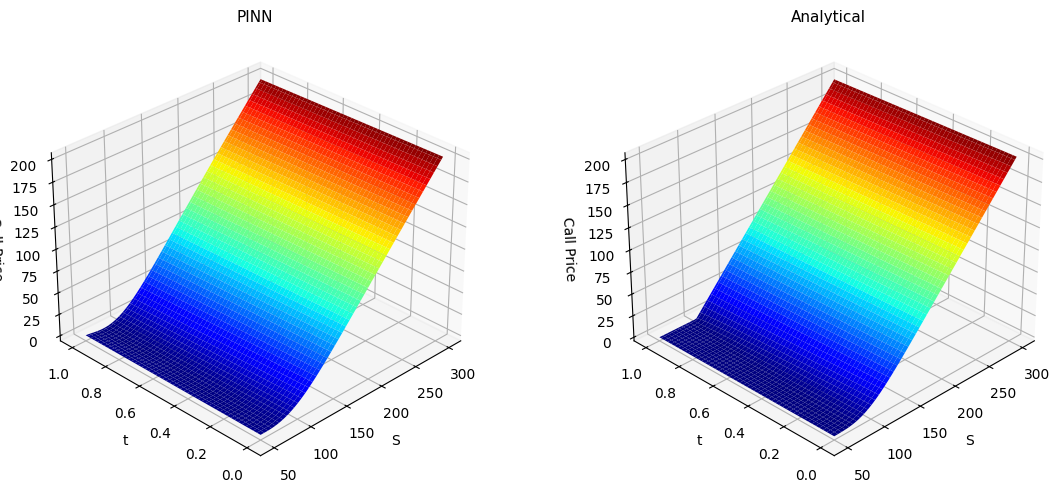

In [ ]:
# --- 3D comparison surfaces (PINN vs Analytical) ---
from mpl_toolkits.mplot3d import Axes3D

# Create 2D grids for S (asset price) and t (time)
S_grid = np.linspace(0.5*K, 3.0*K, 100)
t_grid = np.linspace(0.0, T, 100)
S, Tm = np.meshgrid(S_grid, t_grid)

# Convert to x, tau for PINN evaluation
x_grid = np.log(S / K)
tau_grid = (sigma**2 / 2.0) * (T - Tm)

# Flatten for model input
x_flat = torch.tensor(x_grid.reshape(-1,1), dtype=torch.float32, device=device)
tau_flat = torch.tensor(tau_grid.reshape(-1,1), dtype=torch.float32, device=device)

# Predict with PINN
with torch.no_grad():
    u_pred_flat = model(x_flat, tau_flat).cpu().numpy().flatten()

# Reshape to 2D for plotting
U_pred = u_pred_flat.reshape(x_grid.shape)

# Transform back to option price
V_pred = K * np.exp(a * x_grid + b * tau_grid) * U_pred

# Analytical Black–Scholes prices
V_exact = bs_call_np(S, Tm)

# --- Plot ---
fig = plt.figure(figsize=(12, 5))

# Left: PINN surface
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(S, Tm, V_pred, cmap='jet', edgecolor='none')
ax1.set_title('PINN', fontsize=11)
ax1.set_xlabel('S', fontsize=10)
ax1.set_ylabel('t', fontsize=10)
ax1.set_zlabel('Call Price', fontsize=10)
ax1.view_init(elev=30, azim=-135)

# Right: Analytical surface
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(S, Tm, V_exact, cmap='jet', edgecolor='none')
ax2.set_title('Analytical', fontsize=11)
ax2.set_xlabel('S', fontsize=10)
ax2.set_ylabel('t', fontsize=10)
ax2.set_zlabel('Call Price', fontsize=10)
ax2.view_init(elev=30, azim=-135)

plt.tight_layout()
plt.show()


In [ ]:
# --- Clean up conflicting variables and redefine T ---
del_vars = ['T']
for v in del_vars:
    if v in globals():
        del globals()[v]

# redefine scalar maturity time
T = 1.0  # keep it scalar
print("Reset scalar T =", T)


Reset scalar T = 1.0


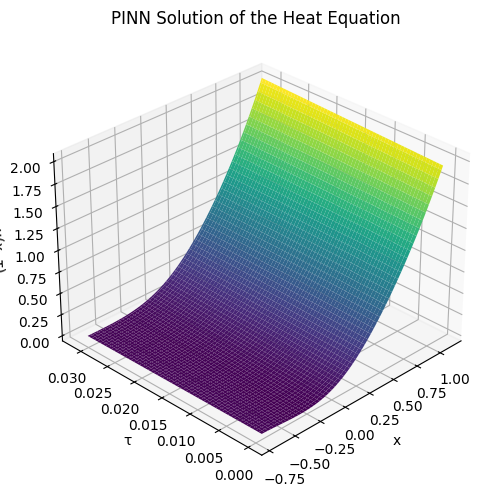

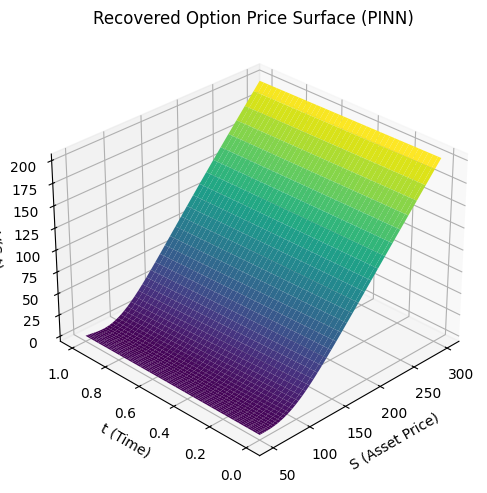

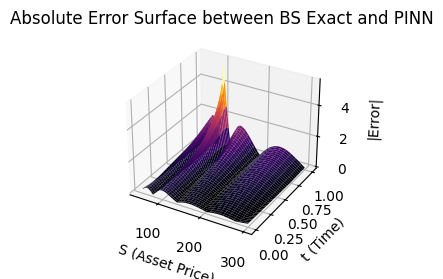

In [ ]:
# --- clean up any old variables ---
import matplotlib.pyplot as plt
import gc
gc.collect()

# --- define grid for evaluation ---
Nx, Nt = 120, 120
x = np.linspace(x_min, x_max, Nx)
tau = np.linspace(0.0, tau_max, Nt)
X, Tau = np.meshgrid(x, tau)   # both are (Nt, Nx)

# --- prepare tensors for model inference ---
x_torch = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
tau_torch = torch.tensor(Tau.flatten(), dtype=torch.float32).unsqueeze(1).to(device)

# --- evaluate u(x, τ) from PINN ---
with torch.no_grad():
    u_pred = model(x_torch, tau_torch).cpu().numpy().reshape(Nt, Nx)

# --- transform back to (S, t) variables ---
S = K * np.exp(X)                      # shape (Nt, Nx)
t = T - (2.0 / (sigma**2)) * Tau       # shape (Nt, Nx)
t = np.clip(t, 0, T)                   # ensure non-negative

V_pred = K * np.exp(a * X + b * Tau) * u_pred
V_exact = bs_call_np(S, t)

# --- 3D Surface: u(x, τ) ---
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X, Tau, u_pred, cmap='viridis' ,rcount=100, ccount=100, linewidth=0, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('τ')
ax.set_zlabel('u(x, τ)')
ax.set_title('PINN Solution of the Heat Equation')
ax.view_init(elev=30, azim=-135)
plt.tight_layout()
plt.show()

# --- 3D Surface: V(S, t) ---
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(S, t, V_pred, cmap='viridis', linewidth=0, antialiased=True)
ax.set_xlabel('S (Asset Price)')
ax.set_ylabel('t (Time)')
ax.set_zlabel('V(S,t)')
ax.set_title('Recovered Option Price Surface (PINN)')
ax.view_init(elev=30, azim=-135)
plt.tight_layout()
plt.show()

# --- 3D Surface: |Error| ---
Error = np.abs(V_exact - V_pred)
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.plot_surface(S, t, Error, cmap='inferno', linewidth=0, antialiased=True)
ax.set_xlabel('S (Asset Price)')
ax.set_ylabel('t (Time)')
ax.set_zlabel('|Error|')
ax.set_title('Absolute Error Surface between BS Exact and PINN')
plt.tight_layout()
plt.show()


In [ ]:
# --- Create evaluation grid ---
Nx, Nt = 120, 120
x = np.linspace(x_min, x_max, Nx)
tau = np.linspace(0.0, tau_max, Nt)
X, Tau = np.meshgrid(x, tau)

# Convert to tensors for model inference
x_torch = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
tau_torch = torch.tensor(Tau.flatten(), dtype=torch.float32).unsqueeze(1).to(device)

# Evaluate u(x, τ)
with torch.no_grad():
    u_pred = model(x_torch, tau_torch).cpu().numpy().reshape(X.shape)

# Transform back to financial variables (consistent shapes)
S = K * np.exp(X)
t = T - (2.0 / (sigma**2)) * Tau  # consistent (Nt x Nx)
t_clipped = np.clip(t, 0, T)

V_pred = K * np.exp(a * X + b * Tau) * u_pred
V_exact = bs_call_np(S, t_clipped)

# --- Surface: u(x, τ) ---
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Tau, u_pred, cmap='viridis', linewidth=0, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('τ')
ax.set_zlabel('u(x, τ)')
ax.set_title('PINN Solution of the Heat Equation')
plt.tight_layout()
plt.show()

# --- Surface: V(S, t) ---
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S, t, V_pred, cmap='plasma', linewidth=0, antialiased=True)
ax.set_xlabel('S (Asset Price)')
ax.set_ylabel('t (Time)')
ax.set_zlabel('V(S,t)')
ax.set_title('Recovered Option Price Surface (PINN)')
plt.tight_layout()
plt.show()

# --- Surface: |Error| ---
Error = np.abs(V_exact - V_pred)
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S, t, Error, cmap='inferno', linewidth=0, antialiased=True)
ax.set_xlabel('S (Asset Price)')
ax.set_ylabel('t (Time)')
ax.set_zlabel('|Error|')
ax.set_title('Absolute Error Surface between BS Exact and PINN')
plt.tight_layout()
plt.show()


ValueError: operands could not be broadcast together with shapes (100,100) (120,120) 

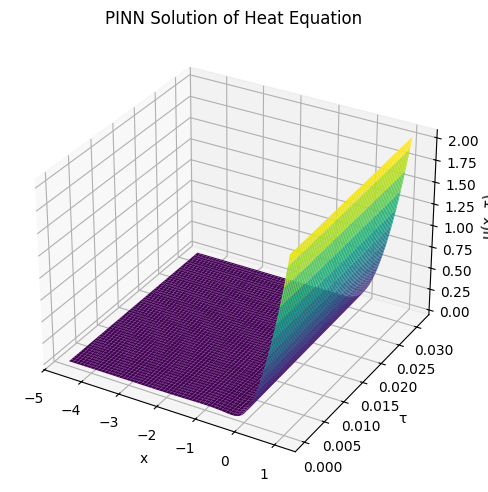

In [ ]:
# --- evaluation grid ---
Nx, Nt = 120, 120
x = np.linspace(x_min, x_max, Nx)
tau = np.linspace(0.0, tau_max, Nt)
X, Tau = np.meshgrid(x, tau)

# Convert to tensors for model inference
x_torch = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
tau_torch = torch.tensor(Tau.flatten(), dtype=torch.float32).unsqueeze(1).to(device)

with torch.no_grad():
    u_pred = model(x_torch, tau_torch).cpu().numpy().reshape(X.shape)

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Tau, u_pred, cmap='viridis', rstride=2, cstride=2)
ax.set_xlabel('x')
ax.set_ylabel('τ')
ax.set_zlabel('u(x, τ)')
ax.set_title('PINN Solution of Heat Equation')
plt.tight_layout()
plt.show()



In [ ]:
# Transform back to S and t
S = K * np.exp(X)
t = T - (2.0 / (sigma**2)) * Tau  # t = T - 2τ/σ²
V_pred = K * np.exp(a * X + b * Tau) * u_pred
V_exact = bs_call_np(S, np.clip(t, 0, T))

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S, t, V_pred, cmap='plasma', linewidth=0, antialiased=True)
ax.set_xlabel('S (Asset Price)')
ax.set_ylabel('t (Time)')
ax.set_zlabel('V(S,t)')
ax.set_title('Recovered Option Price Surface (PINN)')
plt.tight_layout()
plt.show()


ValueError: operands could not be broadcast together with shapes (100,100) (120,120) 

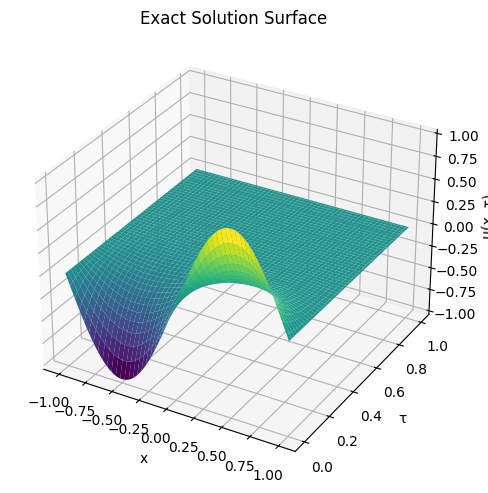

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Grid
x = np.linspace(-1, 1, 100)
tau = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, tau)

# Example exact solution of heat equation
U_exact = np.exp(-np.pi**2 * T) * np.sin(np.pi * X)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, U_exact, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('τ')
ax.set_zlabel('u(x, τ)')
ax.set_title('Exact Solution Surface')
plt.tight_layout()
plt.show()


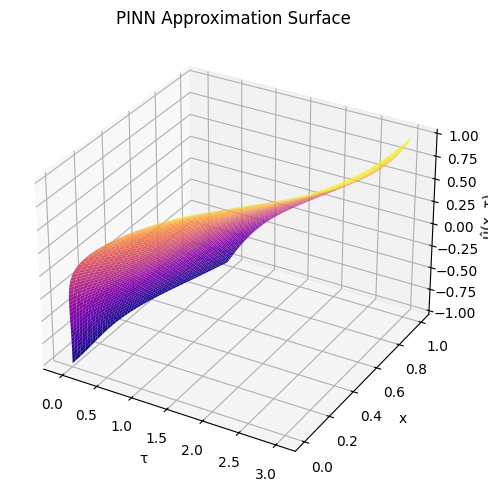

In [ ]:
# Convert grid to tensors
x_torch = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
t_torch = torch.tensor(T.flatten(), dtype=torch.float32).unsqueeze(1).to(device)

# Predict
with torch.no_grad():
    U_pinn = model(x_torch, t_torch).cpu().numpy().reshape(X.shape)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(U_pinn, T, X, cmap='plasma')
ax.set_xlabel('τ')
ax.set_ylabel('x')
ax.set_zlabel('û(x, τ)')
ax.set_title('PINN Approximation Surface')
plt.tight_layout()
plt.show()


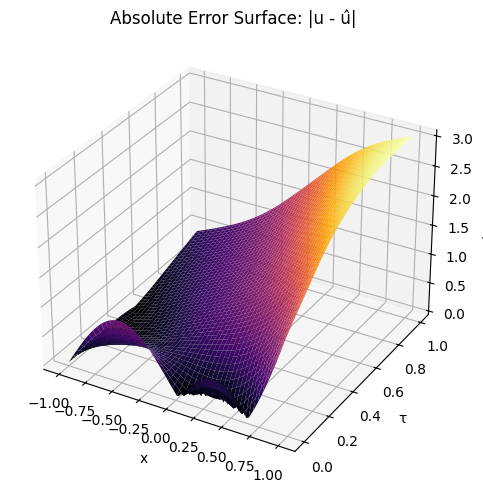

In [ ]:
Error = np.abs(U_exact - U_pinn)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, Error, cmap='inferno')
ax.set_xlabel('x')
ax.set_ylabel('τ')
ax.set_zlabel('|Error|')
ax.set_title('Absolute Error Surface: |u - û|')
plt.tight_layout()
plt.show()
